In [32]:
import os
import re
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import random
import pickle
import cv2 

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [33]:
random.seed(1)
path = '/Users/clarysaaa/Desktop/LSE/LT ma429 machine learning/summative/Images'
folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]

In [34]:
data = []

In [35]:
# Define the target dimensions
#target_width = 50
#target_height = 50

# Iterate through the folders
for folder in folders:
    # Label as healthy or diseased
    if folder.endswith('healthy'):
        label = 1
    else:
        label = 0
    
    # Iterate through the images in the folder
    for image_name in os.listdir(os.path.join(path, folder)):
        # Get the image path
        image_path = os.path.join(path, folder, image_name)
        
        # Read the image using cv2
        img = cv2.imread(image_path)
        
        # Convert the image to grayscale
#        bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Resize the image to the target dimensions
#        resized_img = cv2.resize(bw_img, (target_width, target_height))
        
        # Convert image to pixel values
        pixel_values = np.array(img)
        
        # Add image and label to the dataset
        data.append((pixel_values, label))

In [36]:
data = data[:10000]

In [37]:
data

[(array([[[174, 166, 173],
          [178, 170, 177],
          [180, 172, 179],
          ...,
          [181, 174, 181],
          [165, 158, 165],
          [177, 170, 177]],
  
         [[188, 180, 187],
          [203, 195, 202],
          [172, 164, 171],
          ...,
          [182, 175, 182],
          [235, 228, 235],
          [172, 165, 172]],
  
         [[172, 164, 171],
          [169, 161, 168],
          [185, 177, 184],
          ...,
          [188, 181, 188],
          [193, 186, 193],
          [172, 165, 172]],
  
         ...,
  
         [[157, 147, 159],
          [158, 148, 160],
          [164, 154, 166],
          ...,
          [153, 143, 155],
          [137, 127, 139],
          [135, 125, 137]],
  
         [[153, 143, 155],
          [152, 142, 154],
          [154, 144, 156],
          ...,
          [157, 147, 159],
          [142, 132, 144],
          [135, 125, 137]],
  
         [[150, 140, 152],
          [150, 140, 152],
          [157, 147, 159

In [38]:
# Shuffle the data
random.shuffle(data)

In [39]:
images = [pair[0] for pair in data]

In [40]:
img = images[2]

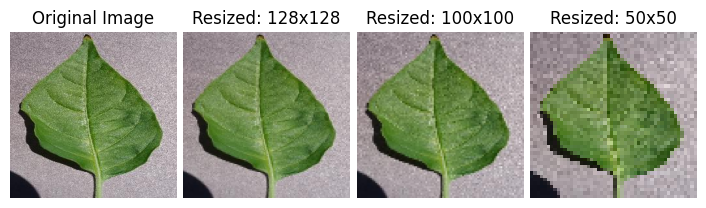

In [45]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for correct color display

# Target dimensions for resizing
sizes = [(128, 128), (100, 100), (50, 50)]

# Create a figure for plotting
plt.figure(figsize=(7, 5))

# Plot the original image
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

# Process and plot each resized image
for i, (width, height) in enumerate(sizes, start=2):
    # Resize the image
    resized_img = cv2.resize(img_rgb, (width, height))

    # Plot resized image
    plt.subplot(1, 4, i)
    plt.imshow(resized_img)
    plt.title(f'Resized: {width}x{height}')
    plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout(pad=0.5)  # Adjust pad value as needed

# Save the plot
plt.savefig('dataset_rgb_resize.png')

# Show the plot
plt.show()

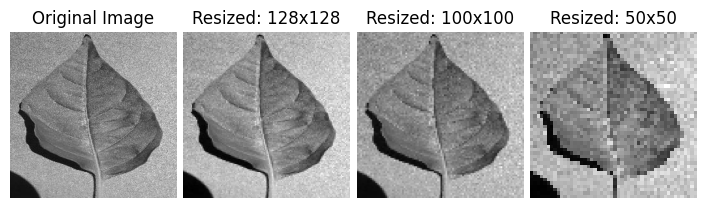

In [44]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to BW for correct color display

# Target dimensions for resizing
sizes = [(128, 128), (100, 100), (50, 50)]

# Create a figure for plotting
plt.figure(figsize=(7, 5))

# Plot the original image
plt.subplot(1, 4, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Process and plot each resized image
for i, (width, height) in enumerate(sizes, start=2):
    # Resize the image
    resized_img = cv2.resize(img_gray, (width, height))

    # Plot resized image
    plt.subplot(1, 4, i)
    plt.imshow(resized_img, cmap='gray')
    plt.title(f'Resized: {width}x{height}')
    plt.axis('off')

# Adjust spacing between subplots
plt.tight_layout(pad=0.5)  # Adjust pad value as needed

# Save the plot
plt.savefig('dataset_bw_resize.png')

# Show the plot
plt.show()

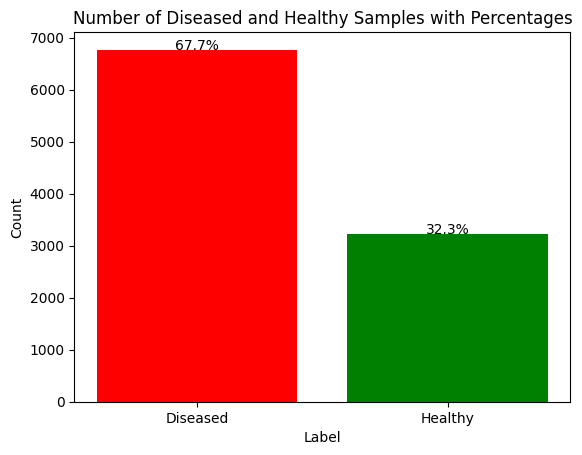

In [15]:
# Data exploration

# Plot a bar chart that shows the proportion of diseased and healthy samples

# Count the occurrences of each label
num_diseased = sum(1 for _, label in data if label == 0)
num_healthy = sum(1 for _, label in data if label == 1)

# Calculate the percentages
total_samples = len(data)
percent_diseased = (num_diseased / total_samples) * 100
percent_healthy = (num_healthy / total_samples) * 100

# Create a bar chart
labels = ['Diseased', 'Healthy']
counts = [num_diseased, num_healthy]
percentages = [percent_diseased, percent_healthy]

fig, ax = plt.subplots()

# Create bar chart for counts
ax.bar(labels, counts, color=['red', 'green'])
ax.set_ylabel('Count', color='black')

# Add percentages as text on top of bars
for i, count in enumerate(counts):
    ax.text(i, count + 5, f'{percentages[i]:.1f}%', ha='center', color='black')

# Show the plot
plt.title('Number of Diseased and Healthy Samples with Percentages')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.savefig('dataset_proportion.png')
plt.show()

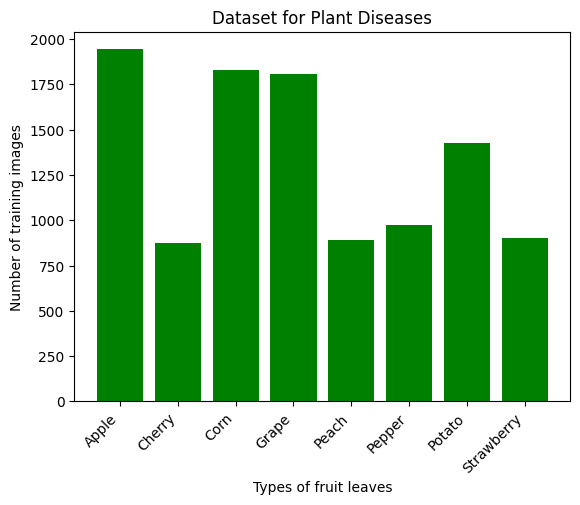

In [16]:
# Data exploration

# Define the types of fruits to search in the folder
target_words = ["Apple", "Cherry", "Corn", "Grape", "Peach", "Pepper", "Potato", "Strawberry"]

# Function to get subfolders containing a specific keyword in their names
def get_subfolders(directory, keyword):
    subfolders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    keyword_subfolders = [folder for folder in subfolders if keyword in folder]
    return keyword_subfolders

# Function to count images in a folder
def count_images_in_folder(directory):
    image_files = [f for f in os.listdir(directory) if re.match(r'.*\.(jpg|jpeg|png|gif)$', f, flags=re.IGNORECASE)]
    return len(image_files)

# Initialize a dictionary to store the number of images for each keyword
images = {}

# Iterate over each subfolder containing the keyword
for word in target_words:
    total_images = 0
    keyword_subfolders = get_subfolders(path, word)
    
    for folder in keyword_subfolders:
        num_images = count_images_in_folder(folder)
        total_images += num_images
    
    images[word] = total_images

# Create a bar chart
plt.bar(images.keys(), images.values(), color=(0/255, 128/255, 0/255))
plt.title("Dataset for Plant Diseases")
plt.xlabel("Types of fruit leaves")
plt.ylabel("Number of training images")
plt.xticks(rotation=45, ha='right')

plt.savefig('dataset_disease.png')
plt.show()

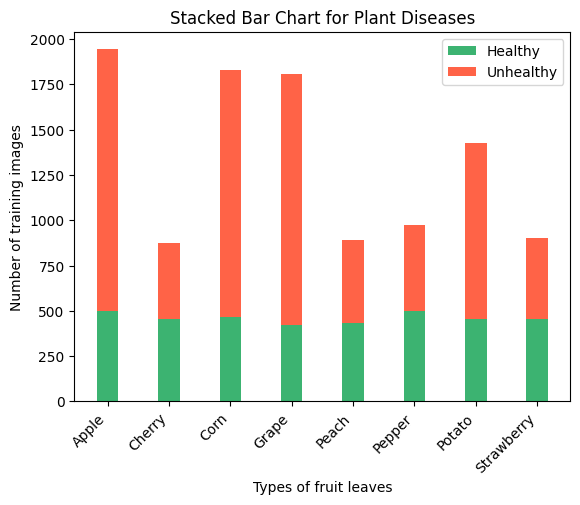

In [17]:
# Data exploration

# Function to get subfolders containing both keywords in their names
def get_subfolders_two(directory, keyword1, keyword2):
    subfolders = [os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    keyword_subfolders = [folder for folder in subfolders if keyword1 in folder and keyword2 in folder]
    return keyword_subfolders

# Function to count images in a folder
def count_images_in_folder(directory):
    image_files = [f for f in os.listdir(directory) if re.match(r'.*\.(jpg|jpeg|png|gif)$', f, flags=re.IGNORECASE)]
    return len(image_files)

# Initialize dictionaries to store the number of images for healthy and unhealthy plants
images_healthy = {}
images_unhealthy = {}

# Iterate over each subfolder containing both keywords
for word in target_words:
    total_images_healthy = 0
    
    keyword_subfolders_healthy = get_subfolders_two(path, word, "healthy")
    
    for folder in keyword_subfolders_healthy:
        num_images = count_images_in_folder(folder)
        total_images_healthy += num_images
    
    images_healthy[word] = total_images_healthy

# Subtract healthy images from total images to get unhealthy images
images_unhealthy = {word: images[word] - images_healthy.get(word, 0) for word in target_words}

# Create a stacked bar chart
x = range(len(target_words))
width = 0.35

fig, ax = plt.subplots()

bars1 = ax.bar(x, images_healthy.values(), width, label='Healthy', color=(60/255, 179/255, 113/255))
bars2 = ax.bar(x, images_unhealthy.values(), width, label='Unhealthy', color=(255/255, 99/255, 71/255), bottom=list(images_healthy.values()))

ax.set_title("Stacked Bar Chart for Plant Diseases")
ax.set_xlabel("Types of fruit leaves")
ax.set_ylabel("Number of training images")
ax.set_xticks(x)
ax.set_xticklabels(target_words)
ax.legend()

plt.xticks(rotation=45, ha='right')

plt.savefig('dataset_disease_stacked.png')
plt.show()